I try to apply what I learned from fastai course on flower dataset. I decide to try with 300 images of Roses and 300 images of Hibiscus since they are quite similiar in colour but different in shape. This notebook is written to test how accurate resnet34 is on these Roses and Hibiscus Dataset. I ran this modelling using google cloud platform as my personal pc has low GPU capabilties.

Each type of flower is divideid into train(200 image) and valid(100 image)

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# The path for this folder will be on the same directory as the notebook
PATH = "Flower/"
sz=224

In [5]:
# Check if cuda is available, CUDA ( the langueage and framework taht nearly alll deep learning libraries and practitioner use)
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

In [11]:
# Check the contain of our path FLower folder
os.listdir(PATH)

['valid', 'train']

In [32]:
os.listdir(f'{PATH}valid')

['Hibiscus', 'Rose']

I encountered an issue of not able to run the deep learning library due to pnyb checkpoint. to solve that, i run the commands below

In [43]:

os.listdir('Flower/train/Rose/.ipynb_checkpoints')

FileNotFoundError: [Errno 2] No such file or directory: 'Flower/train/Rose/.ipynb_checkpoints'

In [42]:
# remove the file that cause the probelm
os.rmdir(f'{PATH}train/Rose/.ipynb_checkpoints')

In [18]:
# Now lets check the files inside the Rose folder
files = os.listdir(f'{PATH}valid/Rose')[:5]
files

['Rose.10.jpg', 'Rose.28.jpg', 'Rose.16.jpg', 'Rose.21.jpg', 'Rose.03.jpg']

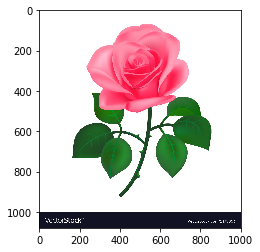

In [19]:
img = plt.imread(f'{PATH}valid/Rose/{files[0]}')
plt.imshow(img);

In [20]:
#check the size of the image
img.shape

(1080, 1000, 3)

In [21]:
img[:4,:4]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)

In [46]:
# Now lets train our model with just 3 lines using fastai library
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.681667   0.328241   0.838098  
    1      0.404298   0.148382   0.934674        



[0.14838177, 0.9346742033958435]

epoch mean how many time that our model will look at our dataset

the last 3 number int the output is the accurary on the validation set. The first two are the value of the loss function 
for the training set and validation set

We achieve accuracy of 93% after running the second epoch!!!

In [48]:
# the data classes, 0 for hibiscus and 1 for roses
data.classes

['Hibiscus', 'Rose']

In [49]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(111, 2)

In [50]:
log_preds[:10]

array([[-0.18451, -1.78088],
       [-0.13364, -2.07871],
       [-0.07411, -2.639  ],
       [-0.59477, -0.80227],
       [-0.02513, -3.69637],
       [-0.00603, -5.11422],
       [-0.00509, -5.28327],
       [-0.0104 , -4.57107],
       [-0.34287, -1.23694],
       [-1.07991, -0.41495]], dtype=float32)

In [51]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])   

In [52]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [53]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [54]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [55]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


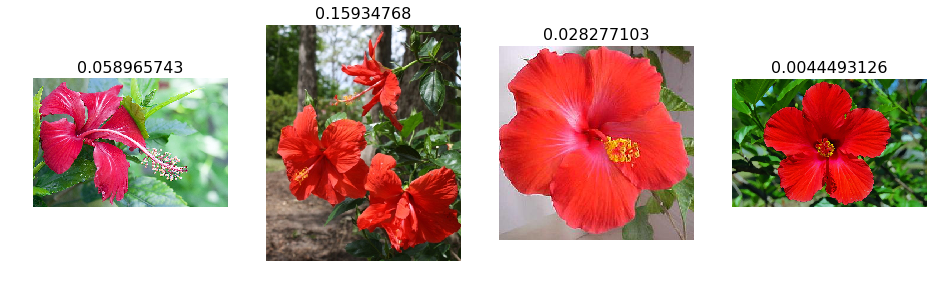

In [56]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


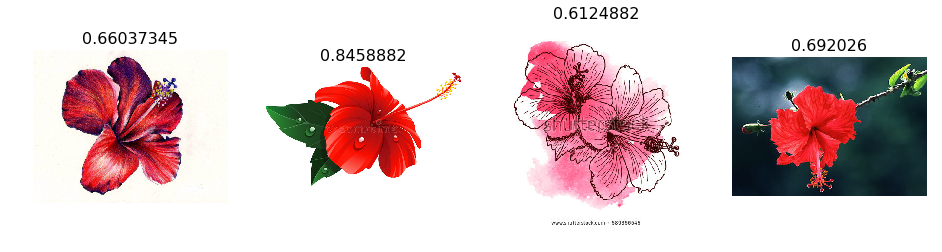

In [66]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [58]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Hibiscus


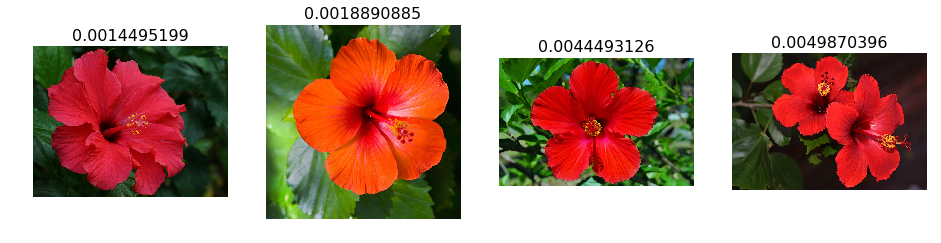

In [67]:
plot_val_with_title(most_by_correct(0, True), "Most correct Hibiscus")

Most correct Rose


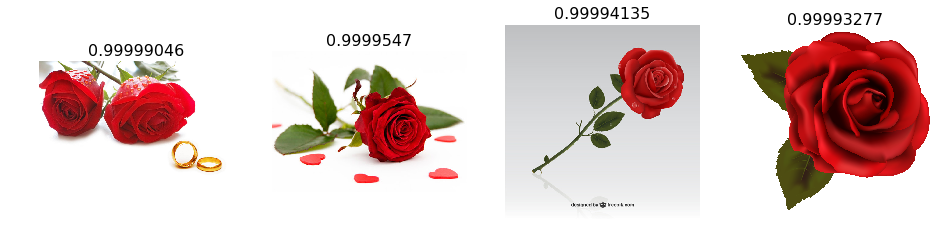

In [61]:
plot_val_with_title(most_by_correct(1, True), "Most correct Rose")

Most incorrect Hibiscus


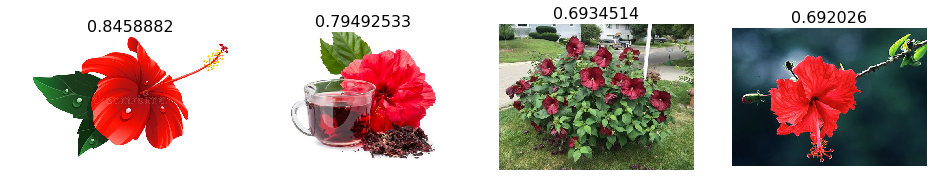

In [62]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Hibiscus")

Most incorrect roses


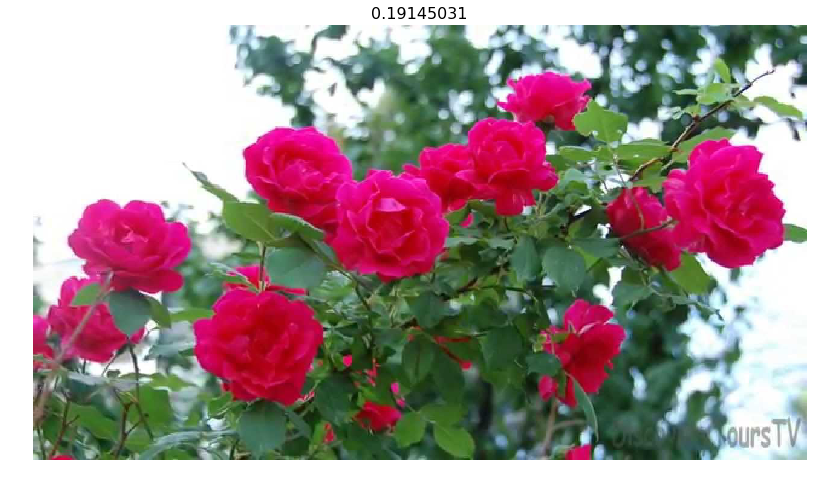

In [63]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect roses")

Most uncertain predictions


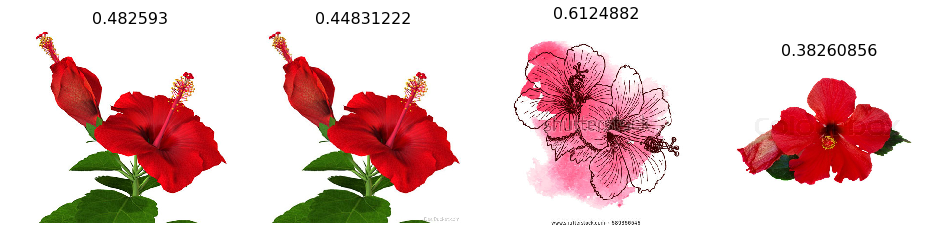

In [64]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Based on our modelling above, the model did very impressive feat by using only 400 images for trainining and yet manage 
to achieve 93% accuracy. We eill try to futher increase the accuracy by tuning our gradient descent

In [72]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

If the learning rate is too small, it will take very long time to get to the bottom


In [73]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.902226   25.898933  0.59375   



Learning rate finder (learn.lr_find) will increase the learning rate after each mini-batch. Eventually, the learning rate 
is too high that loss will get worse. We then look at the plot of learning rate against loss, and determine the lowest point 
and go back by one magnitude and choose that as a learning rate (1e-2 in the example below).

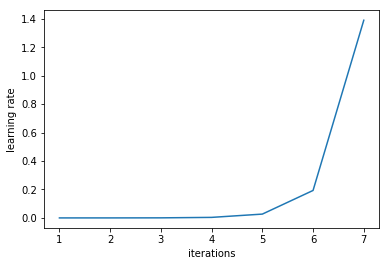

In [74]:
learn.sched.plot_lr()

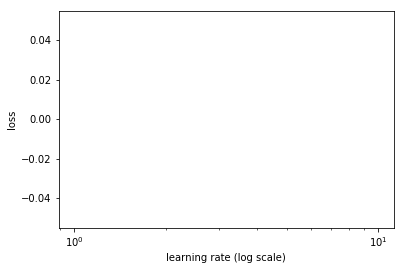

In [75]:
learn.sched.plot()

Every epoch, we will randomly change the image a little bit. In other words, the model is going to see slightly different 
version of the image each epoch.

In [76]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [77]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [78]:
ims = np.stack([get_augs() for i in range(6)])

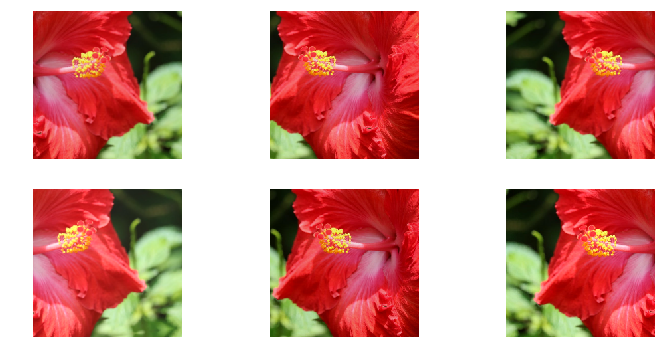

In [79]:
plots(ims, rows=2)

Using data augmentation, we are able to create a different version for a same image to train our model

In [80]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

Now we created a new data object that includes augmentation. Now lets train our model again

In [81]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.60455    0.430373   0.757812  



[0.4303727, 0.7578125]

From the result above, the accuracy decrease alots. This is due the augmentations actually do nothing because of precompute=True.
We are going to change the precompute into false

In [82]:
learn.precompute=False

In [83]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.264977   0.232187   0.903424  
    1      0.207997   0.150372   0.958112                
    2      0.179216   0.105064   0.965924                



[0.10506442, 0.9659242033958435]

From the result, both of the loss for our training set and validation set is decreasing. and our accuracy is increasing to 96%
, compare to 93% before. Notes: Overfitting occur if the training loss is lower than the validation loss

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is 
referred to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). So here's what
our actual learning rates looked like:

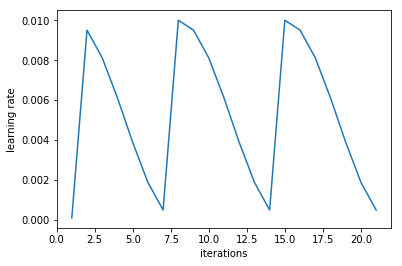

In [84]:
learn.sched.plot_lr()

In [85]:
#save model
learn.save('224_lastlayer')

In [86]:
learn.load('224_lastlayer')

So far, we have not retrained any of pre-trained features — specifically, any of those weights in the convolutional kernels. All we have done is we added some new layers on top and learned how to mix and match pre-trained features.Here is how you tell the learner that we want to start actually changing the convolutional filters themselves:

In [87]:
learn.unfreeze()

“frozen” layer is a layer which is not being trained/updated. unfreeze unfreezes all the layers.

Earlier layers like the first layer (which detects diagonal edges or gradient) or the second layer (which recognizes corners or curves) probably do not need to change by much, if at all.

Later layers are much more likely to need more learning. So we create an array of learning rates (differential learning rate):

In [88]:
lr=np.array([1e-4,1e-3,1e-2])

1e-4 : for the first few layers (basic geometric features)
1e-3 : for the middle layers (sophisticated convolutional features)
1e-2 : for layers we added on top

In [89]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.316262   0.099141   0.976562  
    1      0.240845   0.051788   0.992188                
    2      0.178482   0.051826   0.992188                
    3      0.165607   0.037602   0.992188                
    4      0.135208   0.034341   0.984375                
    5      0.115144   0.035741   0.984375                
    6      0.100029   0.035979   0.984375                



[0.035978593, 0.984375]

In [90]:
learn.save('224_all')

In [91]:
learn.load('224_all')

In [92]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [93]:
accuracy_np(probs, y)

0.9819819819819819

In [94]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

The simple way to look at the result of a classification is called confusion matrix — which is used not only for deep learning but in any kind of machine learning classifier. It is helpful particularly if there are four or five classes you are trying to predict to see which group you are having the most trouble with.

In [95]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[57  1]
 [ 1 52]]


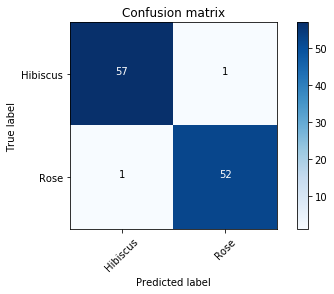

In [96]:
plot_confusion_matrix(cm, data.classes)

Let’s look at the pictures again

Most incorrect Hibiscus


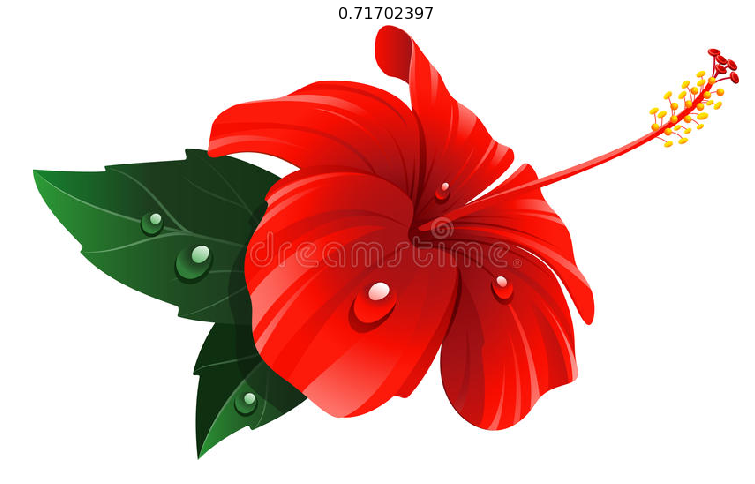

In [98]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Hibiscus")

Most incorrect Rose


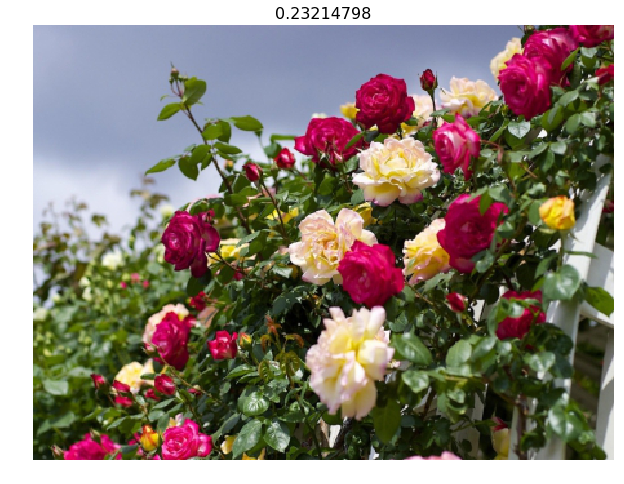

In [100]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Rose")